In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, AveragePooling2D, Conv2DTranspose, Flatten, Reshape, Layer
from tensorflow.keras.models import Model, load_model
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime as dt
import cartopy.feature as cfeature
from sklearn.model_selection import train_test_split

In [2]:
#set the paths
data_path = '/Users/justinhudson/Documents/HW/ATS_780/Homework_2/DATA'
figure_path = '/Users/justinhudson/Documents/HW/ATS_780/Homework_2/FIGURES/'
root = '/Users/justinhudson/Documents/HW/ATS_780/Homework_2'


In [3]:
# set the seed
rand_seed = 144
np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)

### DATA PREPARATION

In [4]:
#bring in the data
os.chdir(data_path)
e5data = Dataset('ERA5_200hpa_U_V_relVort_Colorado_2021_2022.nc')
u = e5data.variables['u'][:]
v = e5data.variables['v'][:]
vort = e5data.variables['vo'][:]
lats = e5data.variables['latitude'][:]
lons = e5data.variables['longitude'][:]
time = e5data.variables['time'][:]
#convert times to usable dates
ref_date = dt.datetime(1900,1,1)
dates = np.array( [ ref_date + dt.timedelta(hours = int(t)) for t in time ] )

In [5]:
#let's limit the data
num_samples = 5000
time_start = np.random.randint(0,len(dates)-num_samples)
u = u[time_start:time_start+num_samples]
v = v[time_start:time_start+num_samples]
vort = vort[time_start:time_start+num_samples]
dates = dates[time_start:time_start+num_samples]

In [6]:
# normalize the data
def normalize_data(dataset:np.ndarray) -> np.ndarray:
    '''
        Normalizes data so that it is on the range 0-1 and then returns
        the normalized data.

        Inputs:
            dataset (np.ndarray): The dataset to be normalized
        
        Outputs:
            norm_data (np.ndarray): The normalized data
    '''

    data_min = np.nanmin(dataset)
    data_max = np.nanmax(dataset)

    norm_data = (dataset[:] - data_min) / (data_max - data_min)

    return norm_data, data_min, data_max

def denormalize_data(normed_data:np.ndarray,orig_min:float,orig_max:float) -> np.ndarray:
    '''
        De-normalizes a dataset using the min and max from the
        original dataset.

        Inputs:
            normed_data (np.ndarray): The dataset to be de-normalized, should
                have a range of [0-1]
            orig_min (float): The original minima of the dataset which was
                used to normalize it
            orig_max (float): The original maxima of the dataset which was
                used to normalize it
        
        Returns:
            denormed_data (np.ndarray): The denormalized dataset which should
                have a range of [orig_min,orig_max]
    '''

    denormed_data = (normed_data * (orig_max - orig_min)) + orig_min

    return denormed_data

u_norm,u_min,u_max = normalize_data(u)
v_norm,v_min,v_max = normalize_data(v)
vort_norm,vort_min,vort_max = normalize_data(vort)

In [7]:
# Combine u and v such that they are images with 2 "channels"
uv_data = np.empty((u.shape[0],u.shape[1],u.shape[2],2))
uv_data[:,:,:,0] = u_norm[:]
uv_data[:,:,:,1] = v_norm[:]
# uv_data is a 4D array of shape (time,lat,lon,channel)

In [8]:
# Split the data in testing/validation/training
# 10% will be testing
# 20% of the remainder will be validation
# the remainder of that will be training data


x_train,x_test,y_train,y_test = train_test_split(uv_data,vort_norm,test_size=0.1,
                                                 shuffle=True, random_state= rand_seed)
#now split off the validation from the training
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,
                                               shuffle = True,random_state= rand_seed)

# print the shapes to verify things look right
print("TRAINING, VALIDATION, AND TESTING SHAPES:")
print(f'XTRAIN: {x_train.shape}, XVAL: {x_val.shape}, XTEST: {x_test.shape}')
print(f'YTRAIN: {y_train.shape}, YVAL: {y_val.shape}, YTEST: {y_test.shape}')

TRAINING, VALIDATION, AND TESTING SHAPES:
XTRAIN: (3600, 25, 41, 2), XVAL: (900, 25, 41, 2), XTEST: (500, 25, 41, 2)
YTRAIN: (3600, 25, 41), YVAL: (900, 25, 41), YTEST: (500, 25, 41)


### Model is Defined Here

Want to use a CNN for this task since spatial information of nearby pixels
is part of how relative vorticity is calculated

In [9]:
def compile_model() -> None:
    '''
        Constructs the CNN Model
    '''
    global model

    # Input Layers
    input_layer = Input(shape=x_train.shape[1:]) # (lat,lon, channels)

    layers = Layer()(input_layer)

    # Convolutional Layers
    for ilay in range(N_CONV_LAYERS):
        layers = Conv2D(N_FILTERS,KERNEL_SIZE, strides = STRIDE,
                        activation = CONV_ACTIVATION, padding = 'same')(layers)

    conv_shape = layers.shape

    output_layer = Conv2D(1, KERNEL_SIZE, activation='linear', padding='same', name = "Output_Layer")(layers)

    # Contruct the model
    model = Model(input_layer,output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,loss = LOSS, metrics=[METRIC])

    model.summary()

def fit_model():
    global history

    history = model.fit(x_train,y_train, epochs = NUM_EPOCHS, verbose=VERBOSITY,
                        batch_size = BATCH_SIZE, shuffle=True, validation_data=[x_val,y_val],
                        callbacks=[early_stopping_callback])

def train_model():
    compile_model()
    fit_model()

In [10]:
# DEFINE MODEL HYPERPARAMETERS HERE

SEED = rand_seed #keep my randomseed the same throughout the notebook

LOSS = 'mse'
METRIC = 'mae'

NUM_EPOCHS = 10000
BATCH_SIZE = 32
VERBOSITY = 2
LEARNING_RATE = 5e-4

# CONVOLUTIONAL LAYER CHOICES
N_CONV_LAYERS = 1
N_FILTERS = 2
KERNEL_SIZE = (3,3)
STRIDE = (1,1)
CONV_ACTIVATION = 'relu'

# DEFINE EARLY STOPPING
PATIENCE = 25
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience=PATIENCE,restore_best_weights=True,
    mode="auto",verbose=1
)

In [11]:
# COMPILE FIT AND THEN TRAIN THE MODEL HERE
#check if model already exists
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(rand_seed)
train_model()
model.save(data_path + f'/MODELS/trainable_model')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 41, 2)]       0         
                                                                 
 layer (Layer)               (None, 25, 41, 2)         0         
                                                                 
 conv2d (Conv2D)             (None, 25, 41, 2)         38        
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 41, 1)         19        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000


2023-11-09 15:36:08.475760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


113/113 - 1s - loss: 0.0944 - mae: 0.2480 - val_loss: 0.0358 - val_mae: 0.1392 - 856ms/epoch - 8ms/step
Epoch 2/10000
113/113 - 1s - loss: 0.0308 - mae: 0.1283 - val_loss: 0.0280 - val_mae: 0.1223 - 579ms/epoch - 5ms/step
Epoch 3/10000
113/113 - 0s - loss: 0.0242 - mae: 0.1128 - val_loss: 0.0224 - val_mae: 0.1083 - 483ms/epoch - 4ms/step
Epoch 4/10000
113/113 - 0s - loss: 0.0196 - mae: 0.1004 - val_loss: 0.0182 - val_mae: 0.0969 - 453ms/epoch - 4ms/step
Epoch 5/10000
113/113 - 0s - loss: 0.0159 - mae: 0.0899 - val_loss: 0.0148 - val_mae: 0.0871 - 454ms/epoch - 4ms/step
Epoch 6/10000
113/113 - 1s - loss: 0.0131 - mae: 0.0812 - val_loss: 0.0122 - val_mae: 0.0790 - 580ms/epoch - 5ms/step
Epoch 7/10000
113/113 - 0s - loss: 0.0109 - mae: 0.0741 - val_loss: 0.0103 - val_mae: 0.0726 - 456ms/epoch - 4ms/step
Epoch 8/10000
113/113 - 0s - loss: 0.0093 - mae: 0.0686 - val_loss: 0.0089 - val_mae: 0.0680 - 452ms/epoch - 4ms/step
Epoch 9/10000
113/113 - 0s - loss: 0.0081 - mae: 0.0648 - val_loss: 0.

INFO:tensorflow:Assets written to: /Users/justinhudson/Documents/HW/ATS_780/Homework_2/DATA/MODELS/trainable_model/assets


INFO:tensorflow:Assets written to: /Users/justinhudson/Documents/HW/ATS_780/Homework_2/DATA/MODELS/trainable_model/assets


In [12]:
# save the model history so I can use it later
np.save(data_path + f'/MODEL_HISTORY/{num_samples}samples_{N_FILTERS}filters_loss.np',history.history["loss"])
np.save(data_path + f'/MODEL_HISTORY/{num_samples}samples_{N_FILTERS}filters_val_loss.np',history.history["val_loss"])


### Model Performance

Loss and MAE Curves

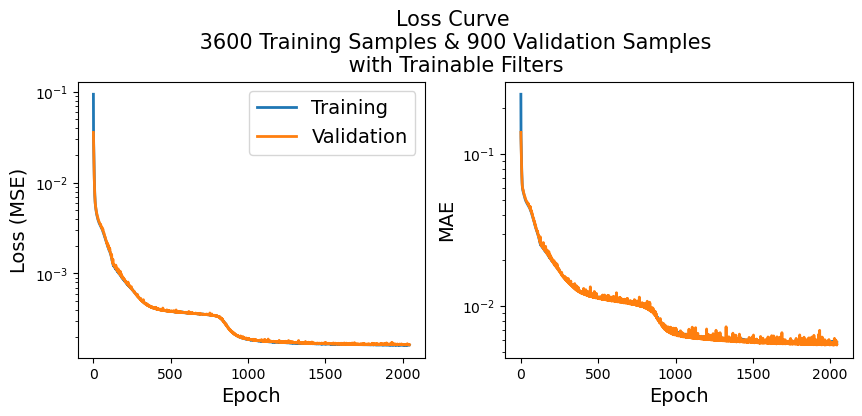

In [15]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

lw = 2

ax[0].plot(history.history["loss"],label = "Training",linewidth = lw)
ax[0].plot(history.history["val_loss"],label = "Validation",linewidth = lw)
ax[0].set_xlabel("Epoch",fontsize = 14)
ax[0].set_ylabel("Loss (MSE)",fontsize = 14)
ax[0].legend(loc = 'best',fontsize = 14)
ax[0].set_yscale('log')

ax[1].plot(history.history["mae"],label = "Training",linewidth = lw)
ax[1].plot(history.history["val_mae"],label = "Validation",linewidth = lw)
ax[1].set_xlabel("Epoch",fontsize = 14)
ax[1].set_ylabel("MAE",fontsize = 14)
#ax[1].legend(loc = 'best')
ax[1].set_yscale('log')

plt.suptitle(f'Loss Curve\n {x_train.shape[0]} Training Samples & {x_val.shape[0]} Validation Samples\n with Trainable Filters',fontsize = 15)

plt.subplots_adjust(top = 0.8,wspace = 0.23)

os.chdir(figure_path)
plt.savefig(f'Trainable_Loss_Curve.png',dpi = 400,bbox_inches = 'tight')

plt.show()

(3, 3, 2, 1)
(3, 3, 2, 2)


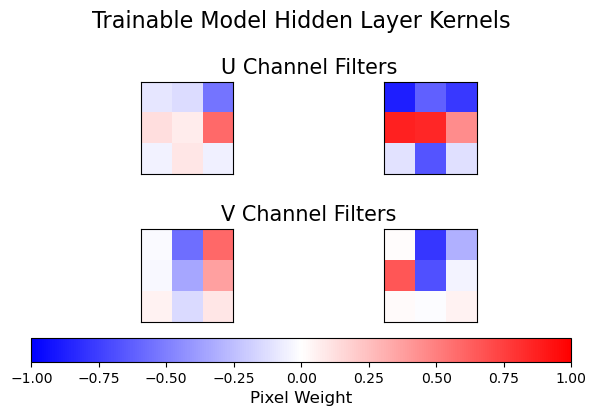

In [16]:
filters,biases = model.layers[2].get_weights()
f_min,f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = N_FILTERS,1

output_filter,output_biases = model.layers[3].get_weights()
print(output_filter.shape)
print(filters.shape)

# cf2 = plt.imshow(filters[:,:,0,1], cmap = 'binary_r')
# plt.show()

fig,tf = plt.subplots(2,1,figsize = (6,4))
tf[0].set_title('U Channel Filters',fontsize = 15)
tf[1].set_title('V Channel Filters',fontsize = 15)
tf[0].set_frame_on(False)
tf[1].set_frame_on(False)
tf[0].axis('off')
tf[1].axis('off')

num_plot = 1
for i in range(2):
    for j in range(n_filters):
        ax = fig.add_subplot(2,n_filters,num_plot)
        if i == 0 and j == 0:
            pl = np.ones((3,3)) * f_max
            pl[0] = f_min
            kshow = ax.imshow(pl,cmap = 'bwr',vmin = -1,vmax = 1)
        ax.imshow(filters[:,:,i,j],cmap = 'bwr',vmin = -1,vmax = 1)
        # ax.set_xticks([0,1,2],['-1','0','+1'])
        # ax.set_yticks([0,1,2],['+1','0','-1'])
        ax.set_xticks([])
        ax.set_yticks([])
        num_plot += 1
# cf0 = ax[0,0].imshow(filters[:,:,0,0], cmap = 'binary_r')

# cf1 = ax[0,1].imshow(filters[:,:,1,0], cmap = 'binary_r')




# cf3 = ax[1,1].imshow(filters[:,:,1,1], cmap = 'binary_r')

plt.subplots_adjust(bottom = 0.2, hspace = 0.6,wspace = 0.1,top = 0.8)

cax = plt.axes([0.05,0.1,0.9,0.06])
cb = plt.colorbar(kshow,cax = cax, orientation = 'horizontal')
cb.set_label(label = 'Pixel Weight',fontsize = 12)
cb.ax.tick_params(labelsize = 10)
cb.set_ticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1.0])

fig.suptitle("Trainable Model Hidden Layer Kernels", fontsize = 16)

plt.savefig(f"Trainable_filters.png",dpi = 400,bbox_inches = 'tight')
plt.show()
    